# Cotton Plant Diesease Detector

# Description
## The dataset is organized into three folders (train, val and test) and contains subfolders for each image category . There are 2293 plant with and without diesease images (JPEG) and 4 categories.

# Problem Statement
- Detect Dieseases in Cotton Plant

# Constraints
- False Negative , is the biggest constraint for any botany based ML & DL based problems, we need to minimize this.
- Latancy is not the problem as tradition approches takes weeks.

# Benifits
- Predicting damage in eyes without using tradition or having domain expertise

## Importing Liberaries

In [28]:
import numpy as np
import pickle
import cv2
import seaborn as sb
from tqdm import tqdm
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.preprocessing import image_dataset_from_directory

## Preparing some variables

In [2]:
train_dir = '/Users/abuzaid/Downloads/Machine Learning/Pianalystics/Cotton/data/train'
val_dir = '/Users/abuzaid/Downloads/Machine Learning/Pianalystics/Cotton/data/val'
test_dir = '/Users/abuzaid/Downloads/Machine Learning/Pianalystics/Cotton/data/test'

EPOCHS = 20
BATCH_SIZE = 256                          #Batch size
IMG_SIZE = (150, 150)                   # Image Size
learning_rate = 0.001
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE,)
val_dataset = image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE,)
test_dataset = image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1951 files belonging to 4 classes.
Found 324 files belonging to 4 classes.
Found 36 files belonging to 5 classes.


## Image Augumentation 

In [3]:
training_datagen = ImageDataGenerator(rescale = 1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,
      shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

testing_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
# Passing the images from datagenerator
train_generator = training_datagen.flow_from_directory(train_dir, target_size=(150,150), class_mode='categorical', batch_size=126)

# Passing Validation data in datagenator
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150,150), class_mode='categorical', batch_size=126)

# Passing Test data in datagenator
test_generator = testing_datagen.flow_from_directory(test_dir, target_size=(150,150), class_mode='categorical', batch_size=126)

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Found 36 images belonging to 5 classes.


## EDA

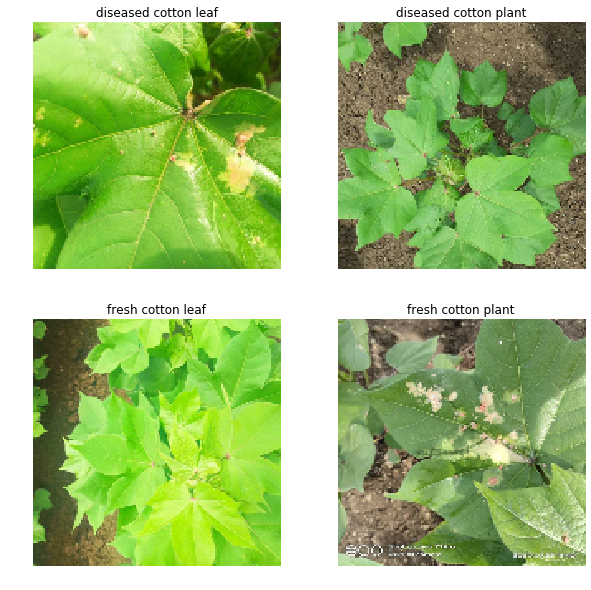

In [5]:
# Ploting  Diffrent Images
class_names = train_dataset.class_names 
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): 
    for i in range(len(class_names)):  
        ax = plt.subplot(2, 2, i + 1)   
        plt.imshow(images[i].numpy().astype("uint8"))   
        plt.title(class_names[i])  
        plt.axis("off")

## Barplot

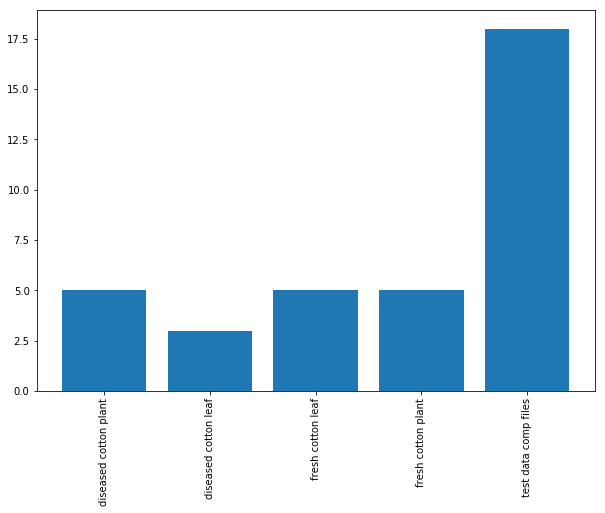

In [13]:
def plot(dirr): # Simple function to count all images in all three folders according to their classes
    image_list, label_list = [], []
    root_dir = listdir(dirr)
    plant_count = {}
    
    for plant_disease_folder in root_dir:
        count = 0
        plant_disease_image_list = listdir(f"{dirr}/{plant_disease_folder}/")
        for image in plant_disease_image_list:
            image_directory = f"{dirr}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                count += 1
        plant_count[plant_disease_folder] = count
    return plant_count




train_dat = plot(train_dir)
val_dat = plot(val_dir)
test_dat = plot(test_dir)

dat = val_dat ,test_dat
for i in dat:
    keys = list(i.keys())
    for key in keys: 
        val = i.get(key)
        train_dat[key] =+ val

data  = train_dat



plt.figure(figsize=(10, 7))
plt.bar(x = list(data.keys()), height = list(data.values()))
plt.xticks(rotation = 90)
plt.show()

## PDF

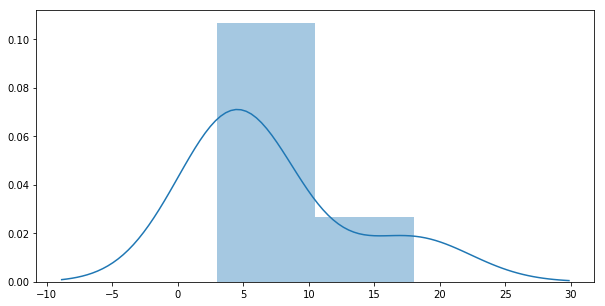

In [14]:
plt.figure(figsize=(10,5))
sb.distplot(list(data.values()))
plt.show()

## Transfer Learning/Creating Model

In [29]:

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(len(class_names), activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=learning_rate, decay=learning_rate / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"]) 

87916544/87910968 [==============================] - 431s 5us/step


In [30]:
earlystoping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min',
  baseline=None, restore_best_weights=True)
history = model.fit(train_generator, epochs=40, steps_per_epoch=10,
                    validation_data = val_generator, verbose = 1, validation_steps=3, callbacks = [earlystoping])

Epoch 1/40
10/10 [==============================] - 104s 10s/step - loss: 1.6635 - accuracy: 0.4833 - val_loss: 0.9121 - val_accuracy: 0.6821
Epoch 2/40
10/10 [==============================] - 107s 11s/step - loss: 0.7432 - accuracy: 0.7238 - val_loss: 0.6435 - val_accuracy: 0.7469
Epoch 3/40
10/10 [==============================] - 79s 8s/step - loss: 0.5952 - accuracy: 0.7657 - val_loss: 0.5776 - val_accuracy: 0.7685
Epoch 4/40
10/10 [==============================] - 90s 9s/step - loss: 0.5698 - accuracy: 0.7866 - val_loss: 0.5550 - val_accuracy: 0.7654
Epoch 5/40
10/10 [==============================] - 139s 14s/step - loss: 0.4553 - accuracy: 0.8301 - val_loss: 0.4422 - val_accuracy: 0.8488
Epoch 6/40
10/10 [==============================] - 116s 12s/step - loss: 0.3696 - accuracy: 0.8636 - val_loss: 0.3692 - val_accuracy: 0.8765
Epoch 7/40
10/10 [==============================] - 152s 15s/step - loss: 0.3617 - accuracy: 0.8627 - val_loss: 0.3576 - val_accuracy: 0.8673
Epoch 8/40

# 88% Accuracy 

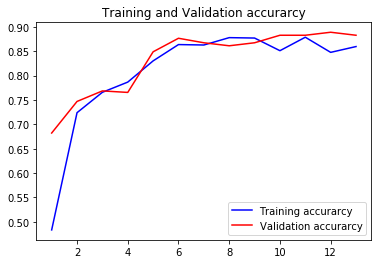

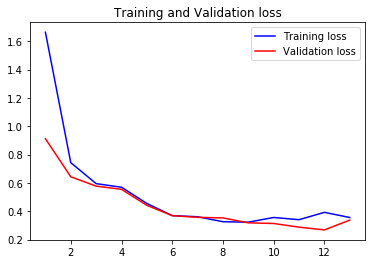

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()